# Word Embedding

In [21]:
from pandas import read_csv, DataFrame, Series
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
from gensim.downloader import load
from sklearn.metrics.pairwise import cosine_similarity
from networkx import draw_networkx, from_numpy_array, write_graphml, read_graphml
from matplotlib.pyplot import get_cmap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import numpy as np
import matplotlib.pyplot as plt
import re

## Datset Creation

In [2]:
raw_questions: DataFrame = read_csv('./data/Questions.csv', encoding='latin-1')
raw_answers: DataFrame = read_csv('./data/Answers.csv', encoding='latin-1')
raw_tags: DataFrame = read_csv('./data/Tags.csv', encoding='latin-1')

In [3]:
raw_answers = raw_answers
raw_answers = raw_answers.where(raw_answers['Score'] >= 10).dropna()
answers_txt = raw_answers['Body'].values

raw_questions = raw_questions.where(raw_questions['Score'] >= 10).dropna()
tag_count = raw_tags['Tag'].value_counts()
best_tags = raw_tags.join(tag_count, on='Tag').dropna()
best_tags = best_tags.loc[best_tags.groupby('Id')['count'].idxmax()]

questions = raw_questions.merge(best_tags[['Id', 'Tag']], on='Id', how='left')
questions = questions.dropna()
questions_txt = questions['Body'].values
questions_title = questions[['Title', 'Score', 'Tag']].sort_values(by='Score', ascending=False)
print(questions_title.head())

                                                  Title  Score         Tag
733   How to replace master branch in git, entirely,...  853.0         git
1312            What is Redis and what do I use it for?  788.0       redis
141   How do you keep parents of floated elements fr...  695.0        html
56    What are the pros and cons of the SVN plugins ...  596.0     eclipse
1527  offsetting an html anchor to adjust for fixed ...  579.0  javascript


In [4]:
# free memory:
del raw_questions
del raw_answers
del questions

In [5]:
def clean_body_content(texts):

	def replace_links(match): # remove href link
		if match.group(1):
			return match.group(1)
		else:
			return ' '

	clean_text = []
	for i, text in enumerate(texts):
		text = re.sub(r'\n', ' ', text)
		text = re.sub(r'<a[^>]*>(.*?)</a>', replace_links, text)
		text = re.sub(r'<[^>]+>', ' ', text)
		clean_text.append(text)
	return clean_text

answers_txt = clean_body_content(answers_txt)
questions_txt = clean_body_content(questions_txt)

full_doc_to_clean = []
full_doc_to_clean.extend(answers_txt)
full_doc_to_clean.extend(questions_title['Title'])
full_doc_to_clean.extend(questions_txt)

In [6]:
tfidf = TfidfVectorizer()
tfidf.fit_transform(full_doc_to_clean)
tfidf_dict = {}
for ele1, ele2 in zip(tfidf.get_feature_names_out(), tfidf.idf_):
    tfidf_dict[ele1] = ele2
tfidf_res = Series(tfidf_dict)
print(tfidf_res.describe())
tfidf_res = tfidf_res.sort_values()
useless_word = tfidf_res.where(tfidf_res >= tfidf_res.mean()).dropna()
useless_word.index

count    208734.000000
mean         11.162529
std           0.978652
min           1.222639
25%          11.182381
50%          11.587846
75%          11.587846
max          11.587846
dtype: float64


Index(['â³', 'âº', 'ã³å', 'dmaxbitmap', '½í²¼', '½í²¾', '½í³', '½wï', '¼ã',
       '¼í¾',
       ...
       'øºû', 'ù¾', 'ù¾ø', 'û²',
       '000000000000000000000000000000000000000000001401', 'û³', 'ûµ',
       '00000000000000000000000000000000000000000000006842277657836021',
       '000000000000000000000000000000000000000000000000',
       '000000000000000000'],
      dtype='object', length=166203)

In [7]:
pattern = re.compile(r'^\d+$') # only number
def clean_stop_words(text: str) -> str:
	words = text.split(' ')
	words = [word for word in words if (word.lower() not in ENGLISH_STOP_WORDS 
									    and word.lower() not in useless_word.index
										and not pattern.match(word))]
	return " ".join(words)
full_doc_clean = [clean_stop_words(text) for text in full_doc_to_clean]
questions_title['Title'] = questions_title['Title'].apply(clean_stop_words)

## Analyse

### Train

In [ ]:
class MyCorpus:
	def __iter__(self):
		for line in full_doc_to_clean:
			yield simple_preprocess(line)

sentences = MyCorpus()
model_raw = Word2Vec(sentences, sg=1, epochs=10, workers=8) # take long time
model_raw.save("data/word2vec_raw.model")

In [ ]:
class MyCorpus:
	def __iter__(self):
		for line in full_doc_clean:
			yield simple_preprocess(line)

sentences = MyCorpus()
model = Word2Vec(sentences, sg=1, epochs=10, workers=8) # take long time
model.save("data/word2vec.model")

### Test

In [8]:
pretrain_model = load('word2vec-google-news-300') # take long time
model = Word2Vec.load('./data/word2vec.model')
model_raw = Word2Vec.load('./data/word2vec_raw.model')
print(pretrain_model.most_similar(positive=['java'], topn=5))
print(model.wv.most_similar(positive=['java'], topn=5))
print(model_raw.wv.most_similar(positive=['java'], topn=5))
del pretrain_model

[('coffee', 0.6504806876182556), ('o_joe', 0.6308027505874634), ('chai_latte', 0.5802704095840454), ('joe', 0.5795696973800659), ('espresso', 0.567435085773468)]
[('defineclass', 0.7294931411743164), ('jdk', 0.7228733897209167), ('doprivileged', 0.695932149887085), ('util', 0.6745361685752869), ('invokenative', 0.6708270311355591)]
[('defineclass', 0.7419677376747131), ('util', 0.7028791308403015), ('lang', 0.6966675519943237), ('jdk', 0.6935417652130127), ('urlclassloader', 0.6897762417793274)]


Cette comparaison démontre l'importance de ne pas utiliser un modèle pré-entrainé, car le sens de mot ne sera pas saisit de la même façon qu'avec notre dataset

### new model

In [12]:
class Doc2vec:
	def __init__(self, path_to_model, tfidf_dict):
		self.word2vec = Word2Vec.load(path_to_model)
		self.tfidf_dict: dict = tfidf_dict
	
	def encode(self, sentence):
		vec = np.zeros((1, self.word2vec.vector_size))
		for word in sentence.split(" "):
			try:
				if word.lower() in self.tfidf_dict.keys():
					vec += self.tfidf_dict[word.lower()] * self.word2vec.wv[word.lower()]
				else:
					vec += self.word2vec.wv[word.lower()]
			except:
				pass
		return vec
	
	
	def similarity(self, sentence1, sentence2):
		vec1 = self.encode(sentence1)
		vec2 = self.encode(sentence2)
		return cosine_similarity(vec1, vec2).item()
	
	def series_similarity(self, sentences):
		res = dict()
		for i in range(len(sentences)):
			if i%100==0:
				print(i) 
			for j in range(i, len(sentences)):
				if i != j:
					similarity = self.similarity(sentences[i], sentences[j])
					res[(i, j)] = similarity
		return Series(res)
	
	def matrix_similarity(self, sentences, tags, scores):
		res = np.empty(shape=(len(sentences), len(sentences)))
		attr = []
		for i in range(len(sentences)):
			if i%100==0:
				print(i)
			attr.append({"Title": sentences[i],
						"Tag": tags[i],
						"Score": scores[i]})
			for j in range(i, len(sentences)):
				if i != j:
					similarity = self.similarity(sentences[i], sentences[j])
					res[i, j] = similarity
					res[j, i] = similarity
				else:
					res[i, j] = 0
		
		return res, attr

tfidf = TfidfVectorizer()
tfidf.fit_transform(questions_title['Title'].values)
tfidf_dict = {}
for ele1, ele2 in zip(tfidf.get_feature_names_out(), tfidf.idf_):
    tfidf_dict[ele1] = ele2

doc_model = Doc2vec('./data/word2vec.model', tfidf_dict)
doc_model_raw = Doc2vec('./data/word2vec_raw.model', tfidf_dict)
doc_model_visu = Doc2vec('./data/word2vec_visu.model', tfidf_dict)
doc_model.encode(questions_title['Title'].iloc[0])

array([[ -1.74145374,   7.13591278,   9.80003977,  -3.51707065,
         -2.3119847 ,  -9.99268222,  11.98233438,  16.4388864 ,
         -3.64967512,   7.50450349,  -4.88180208,   4.14708328,
          4.07060397,  -5.62016952,  -0.64670372, -16.61713237,
          7.12667704,  -7.97597861,  12.47001696,  -5.85286507,
         -5.3398173 ,   4.84804374,   0.28229859,   5.03218389,
          7.83199954,   2.98497283,  -2.62819217,   9.05137545,
         -3.32019866,  -3.74230944,   4.00656317,   4.0905315 ,
         -5.31545749,  -4.37899369,  -1.85748893,  -0.65291959,
          6.23351085,  -0.92080617,  -6.31402481,  -5.57954185,
        -15.99255586,  12.19640636,   6.34381223,  -6.01521873,
          1.17402571,   8.08700497,  -7.69642842,   0.91221774,
          8.4324823 ,   1.74248789,  -3.46254873,  -8.70273685,
         -9.94228292,  -1.38584675,  -4.82479294,   1.12298174,
         -4.58894211,   1.61429417,  -5.47786638,  -6.4511987 ,
         13.2533116 ,  -1.85420725,  -3.

In [ ]:
questions_title.iloc[:50]

In [17]:
print(questions_title['Title'].loc[188], '/', questions_title['Title'].loc[1483], 
doc_model_raw.similarity(questions_title['Title'].loc[188], questions_title['Title'].loc[1483]))
print()
print(questions_title['Title'].loc[999], '/', questions_title['Title'].loc[1060], 
doc_model_raw.similarity(questions_title['Title'].loc[999], questions_title['Title'].loc[1060]))
print()
print(questions_title['Title'].loc[1143], '/', questions_title['Title'].loc[236], 
doc_model_raw.similarity(questions_title['Title'].loc[1143], questions_title['Title'].loc[236]))
print()
print(questions_title['Title'].loc[1188], '/', questions_title['Title'].loc[733], 
doc_model_raw.similarity(questions_title['Title'].loc[1188], questions_title['Title'].loc[733]))


iframes considered 'bad practice'? / Make iframe automatically adjust height according contents using scrollbar? 0.5568226851437773

use StringBuilder java / Java - Convert integer string 0.6645286777492052

Need minimal Django file upload example / common uses Python decorators? 0.5727217958626232

does Ajax response like 'for (;;); { json data }' mean? / replace master branch git, entirely, branch? 0.41241514372766747


In [18]:
print(questions_title['Title'].loc[188], '/', questions_title['Title'].loc[1483], 
doc_model.similarity(questions_title['Title'].loc[188], questions_title['Title'].loc[1483]))
print()
print(questions_title['Title'].loc[999], '/', questions_title['Title'].loc[1060], 
doc_model.similarity(questions_title['Title'].loc[999], questions_title['Title'].loc[1060]))
print()
print(questions_title['Title'].loc[1143], '/', questions_title['Title'].loc[236], 
doc_model.similarity(questions_title['Title'].loc[1143], questions_title['Title'].loc[236]))
print()
print(questions_title['Title'].loc[1188], '/', questions_title['Title'].loc[733], 
doc_model.similarity(questions_title['Title'].loc[1188], questions_title['Title'].loc[733]))


iframes considered 'bad practice'? / Make iframe automatically adjust height according contents using scrollbar? 0.5748503871098735

use StringBuilder java / Java - Convert integer string 0.6566074202296966

Need minimal Django file upload example / common uses Python decorators? 0.6151118627907347

does Ajax response like 'for (;;); { json data }' mean? / replace master branch git, entirely, branch? 0.36471989100891106


In [19]:
res_raw = doc_model_raw.series_similarity(questions_title['Title'].values[:500])
res_raw.describe()

0
100
200
300
400


count    124750.000000
mean          0.405248
std           0.127326
min          -0.034248
25%           0.326977
50%           0.408205
75%           0.488648
max           1.000000
dtype: float64

In [20]:
res = doc_model.series_similarity(questions_title['Title'].values[:500])
res.describe()

0
100
200
300
400


count    124750.000000
mean          0.416123
std           0.124906
min          -0.008726
25%           0.340822
50%           0.419309
75%           0.498311
max           1.000000
dtype: float64

## Visualise

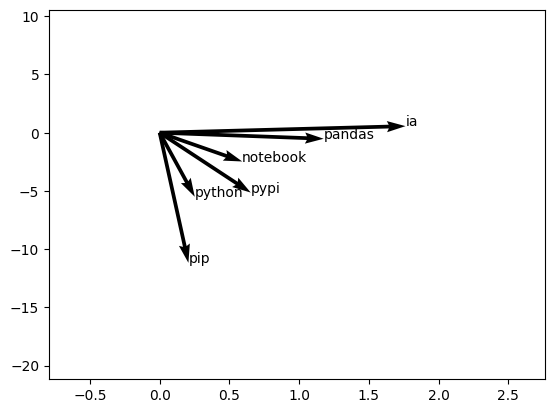

In [9]:
model = Word2Vec.load('./data/word2vec_visu.model')

total_encode = []
final_tag = ['ia', 'python', 'pandas', 'notebook', 'pip', 'pypi']

for tag in final_tag:
	try:
		total_encode.append(model.wv[tag])
	except Exception as e:
		print(str(e))		
total_encode = DataFrame(total_encode)

fig, ax = plt.subplots()
ax.quiver([0 for _ in range(len(total_encode))], [0 for _ in range(len(total_encode))], total_encode[0], total_encode[1], angles='xy', scale_units='xy', scale=1)

# Ajouter les labels
for i, tag in enumerate(final_tag):
    ax.annotate(tag, (total_encode[0][i], total_encode[1][i]))
# Définir les limites du plot pour inclure toutes les flèches
ax.set_xlim([min(total_encode[0]) - 1, max(total_encode[0]) + 1])
ax.set_ylim([min(total_encode[1]) - 10, max(total_encode[1]) + 10])
plt.show()

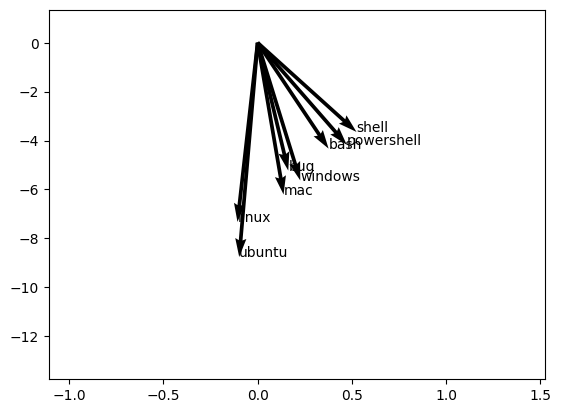

In [10]:
total_encode = []
final_tag = ['linux', 'windows', 'mac', 'ubuntu', 'powershell', 'bash', 'shell', 'bug']

for tag in final_tag:
	try:
		total_encode.append(model.wv[tag])
	except Exception as e:
		print(str(e))		
total_encode = DataFrame(total_encode)

fig, ax = plt.subplots()
ax.quiver([0 for _ in range(len(total_encode))], [0 for _ in range(len(total_encode))], total_encode[0], total_encode[1], angles='xy', scale_units='xy', scale=1)

# Ajouter les labels
for i, tag in enumerate(final_tag):
    ax.annotate(tag, (total_encode[0][i], total_encode[1][i]))
# Définir les limites du plot pour inclure toutes les flèches
ax.set_xlim([min(total_encode[0]) - 1, max(total_encode[0]) + 1])
ax.set_ylim([min(total_encode[1]) - 5, max(total_encode[1]) + 5])
plt.show()

In [16]:
print(tfidf_dict['linux'])
print(tfidf_dict['windows'])
print(tfidf_dict['mac'])

5.415126583100227
5.117875059632294
6.0341657915064495


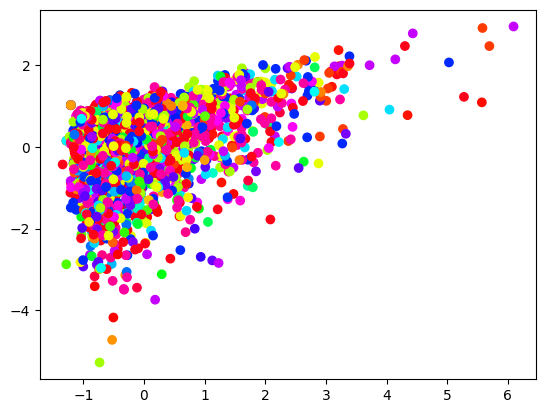

In [13]:
total_encode = []
for question in questions_title['Title'].values:
	total_encode.append(doc_model_visu.encode(question)[0])
total_encode = DataFrame(total_encode)
total_encode

scaler = StandardScaler()
scaler.fit(total_encode)
encode_norm = scaler.transform(total_encode)
encode_norm = DataFrame(encode_norm)

# colorise by tag
cmap = get_cmap('hsv')
tags = set()
c_tag = {}
for tag in questions_title['Tag'].values:
	tags.add(tag)
for i, tag in enumerate(tags):
	c_tag[tag] = cmap(i)
color = []
for tag in questions_title['Tag'].values:
	color.append(c_tag[tag])
fig, ax = plt.subplots()
ax.scatter(encode_norm[0], encode_norm[1], c=color)
plt.show()

## Graphe

In [24]:
matrix, attr = doc_model.matrix_similarity(questions_title['Title'].values[:500], questions_title['Tag'].values[:500], questions_title['Score'].values[:500])

0
100
200
300
400


In [ ]:
matrix_adj = np.where(matrix > 0.7, 1, 0)
G = from_numpy_array(matrix_adj)
draw_networkx(G)

In [23]:
def remove_node(G, min_degree):
	remove_list = []
	for node in G.nodes:
		if G.degree(node) < min_degree:
			remove_list.append(node)
	G_local = G.copy()
	G_local.remove_nodes_from(remove_list)
	return G_local

G_clean1 = remove_node(G, 1)

cmap = get_cmap('hsv')
tags = set()
c_tag = {}
for at in attr:
	tags.add(at['Tag'])
for i, tag in enumerate(tags):
	c_tag[tag] = cmap(i)
color = []
for node in G_clean1.nodes:
	G_clean1.nodes[node]["tag"] = attr[node]['Tag']
	G_clean1.nodes[node]["score"] = attr[node]['Score']
	G_clean1.nodes[node]["title"] = attr[node]['Title']
	color.append(c_tag[attr[node]["Tag"]])
draw_networkx(G_clean1, with_labels=False, node_color=color)
write_graphml(G_clean1, './data/word2vec_graph.graphml')

NameError: name 'attr' is not defined

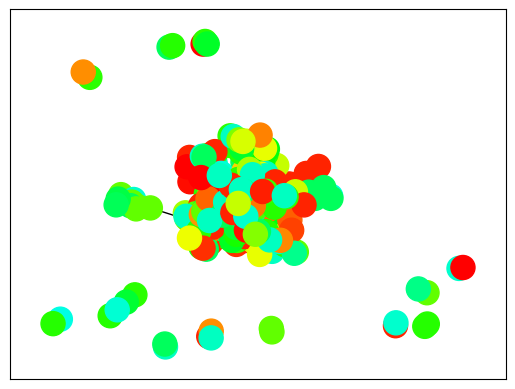

In [26]:
G = read_graphml('./data/word2vec_graph.graphml')
cmap = get_cmap('hsv')
tags = set()
c_tag = {}
for at in attr:
	tags.add(at['Tag'])
for i, tag in enumerate(tags):
	c_tag[tag] = cmap(i)
color = []
for node in G_clean1.nodes:
	color.append(c_tag[G.nodes[node]["tag"]])
draw_networkx(G_clean1, with_labels=False, node_color=color)